In [68]:
import gurobipy as gp
from gurobipy import GRB
import pickle
from copy import deepcopy
import random 
import numpy as np
from matplotlib import pyplot as plt


In [69]:
# Nodes
n = 7
clients = [ i for i in range(n) if i !=0]
nodes = [0]+clients #+[n-1]
arcs = [(i,j) for i in nodes for j in nodes if i!=j]
cost = random.sample(range(20,200),len(arcs))
c = { arcs[i]:  cost[i] for i in range(len(arcs))}

np.random.seed(0)
q = {n:np.random.randint(10,15) for n in clients}
#q[0] = 0
#q[6] = 0
Q = 1000

# coordinates
X = np.random.rand(len(nodes))*100
Y = np.random.rand(len(nodes))*100

In [70]:
# distance
distance = {(i,j): np.hypot(X[i]-X[j],Y[i]-Y[j]) for i in nodes for j in nodes if i!=j}


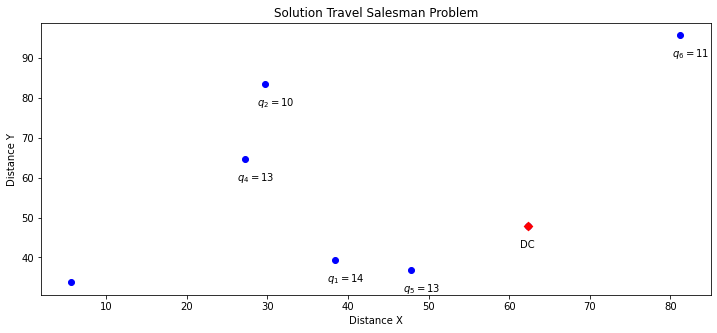

In [71]:
plt.figure(figsize=(12,5))
plt.scatter(X,Y,color =  'blue')

#DC
plt.scatter(X[0],Y[0],color = 'red', marker='D')
plt.annotate('DC',(X[0]-1,Y[0]-5.5))

for i in clients:
    plt.annotate('$q_{%d}=%d$'%(i,q[i]),(X[i]-1,Y[i]-5.5))
    
plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('Solution Travel Salesman Problem')
plt.show()

In [72]:
# not connected!
#arcs = [(0,1),(0,2), (0,5), (1,2),(1,3),(1,4),(1,5),(1,6),(2,3),(2,6),(3,4),(4,5),(5,6),(2,1),(3,1),(4,1),(5,1),(3,2),(4,3),(5,4)]
#cost = [11,10,10,5,15,15,5,10,15,10,20,15,10,5,15,15,5,15,20,15]
#c = { arcs[i]:  cost[i] for i in range(len(arcs))}

In [73]:
# Create Model
m = gp.Model('CVRP')

In [74]:
# Adding variables
x = m.addVars(arcs,vtype = GRB.BINARY,name='x')         # x = arcs
u = m.addVars(clients,ub = Q,vtype = GRB.CONTINUOUS,name='u')  # u = clients

In [75]:
# Objective Function
#m.setObjective(gp.quicksum(c[i,j]*x[i,j] for i,j in arcs),GRB.MINIMIZE)
m.setObjective(gp.quicksum(distance[n]*x[n] for n in arcs),GRB.MINIMIZE)

In [76]:
#Constraints

# first constraint: check that each customer is visited once by a vehicle
m.addConstrs(gp.quicksum(x[i,j] for j in nodes if j!= i) == 1 for i in clients)
# second constraint: check that if a vehicle visits a client, the vehicle leaves the client
m.addConstrs(gp.quicksum(x[i,j] for i in nodes if j!= i) == 1 for j in clients)
# third constraint: avoid subtours (TO TAKE OUT LATER)
m.addConstrs((x[i,j]==1) >> (u[i]+q[j]== u[j]) for i,j in arcs if j!=0 and i!=0)

m.addConstrs(u[i]>=q[i] for i in clients)
m.addConstrs(u[i]<= Q for i in clients)

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>}

In [77]:
m.Params.timeLimit = 60
m.Params.MIPGap = 0.1
m.optimize()

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 24 rows, 48 columns and 84 nonzeros
Model fingerprint: 0x21a1358b
Model has 30 general constraints
Variable types: 6 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+00, 1e+03]
  GenCon rhs range [1e+01, 1e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 18 rows and 0 columns
Presolve removed 0 rows and 12 columns
Presolve time: 0.00s
Presolved: 42 rows, 36 columns, 180 nonzeros
Variable types: 6 continuous, 30 integer (30 binary)
Found heuristic solution: objective 299.9926958

Root relaxation: objective 2.190814e+02, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds    

In [78]:
print('Objective Function: ',str(round(m.ObjVal,2)))
for v in m.getVars():
    if v.x > 0.9:
        print(str(v.VarName)+'='+str(v.x))
        

Objective Function:  238.29
x[0,1]=1.0
x[1,5]=1.0
x[2,6]=1.0
x[3,4]=1.0
x[4,2]=1.0
x[5,3]=1.0
x[6,0]=1.0
u[1]=14.0
u[2]=62.999999999999545
u[3]=39.999999999999545
u[4]=52.999999999999545
u[5]=26.999999999999545
u[6]=73.99999999999955


In [79]:
routes = list()
for i in clients:
    if x[(0,i)].x > 0.9:
        aux = [0,i]
        while i != 0:
            j = i
            for k in nodes:
                if j!=k and x[(j,k)].x > 0.9:
                    aux.append(k)
                    i=k
        routes.append(aux)
routes

[[0, 1, 5, 3, 4, 2, 6, 0]]

Text(0.5, 1.0, 'Vehicle Routing Problem')

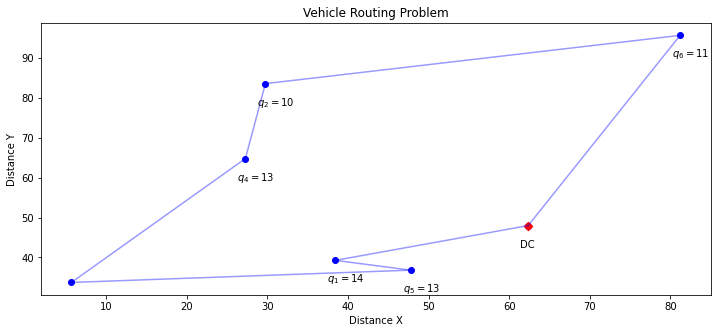

In [80]:
import colour as cl

plt.figure(figsize=(12,5))
plt.scatter(X,Y,color = 'blue')

#DC
plt.scatter(X[0],Y[0],color='red',marker='D')
plt.annotate('DC',(X[0]-1,Y[0]-5.5))

for i in clients:
    plt.annotate('$q_{%d}=%d$'%(i,q[i]),(X[i]-1,Y[i]-5.5))
    
for r in range(len(routes)):
    for n in range(len(routes[r])-1):
        i = routes[r][n]
        j = routes[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]],color = 'blue',alpha = 0.4)
        
plt.xlabel('Distance X')
plt.ylabel('Distance Y')
plt.title('Vehicle Routing Problem')